In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import networkx as nx
import json

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

from train_ import train

Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'wurlitzer', 'graph_tool', 'infomap', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg'}


{'data_path': '../data/karate.adjlist', 'outf': 'example', 'maxlen': 100, 'nhidden': 2, 'emsize': 30, 'nlayers': 1, 'noise_radius': 0.2, 'noise_anneal': 0.995, 'hidden_init': False, 'arch_g': '300-300', 'arch_d': '300-300', 'z_size': 100, 'temp': 1, 'enc_grad_norm': True, 'gan_toenc': -0.01, 'dropout': 0.0, 'epochs': 50, 'walk_length': 20, 'numWalks_per_node': 30, 'batch_size': 64, 'niters_ae': 1, 'niters_gan_d': 5, 'niters_gan_g': 1, 'niters_gan_schedule': '2-4-6-10-20-30-40', 'min_epochs': 6, 'no_earlystopping': False, 'lr_ae': 1, 'lr_gan_g': 5e-05, 'lr_gan_d': 1e-05, 'beta1': 0.9, 'clip': 1, 'gan_clamp': 0.01, 'sample': False, 'log_interval': 200, 'seed': 1111, 'cuda': False, 'ntokens': 34}
e:\CommunityDetectionModel\NetRA\src
middle point:
15.690000000025409
probability of the middle point:
0.018976107992499183


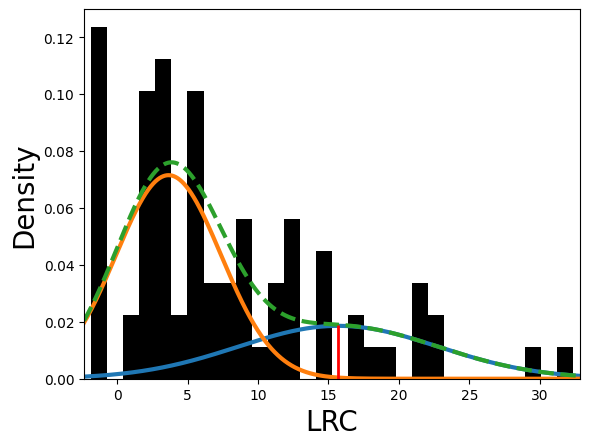

./tmp/train.txt
Number of lines in total: 1020
Vocabulary Size: 34
Loaded data!
Seq2Seq(
  (embedding): Embedding(34, 30)
  (embedding_decoder): Embedding(34, 30)
  (encoder): LSTM(30, 2, batch_first=True)
  (decoder): LSTM(32, 2, batch_first=True)
  (linear): Linear(in_features=2, out_features=34, bias=True)
)
MLP_G(
  (layer1): Linear(in_features=100, out_features=300, bias=True)
  (bn1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): ReLU()
  (layer2): Linear(in_features=300, out_features=300, bias=True)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation2): ReLU()
  (layer7): Linear(in_features=300, out_features=2, bias=True)
)
MLP_D(
  (layer1): Linear(in_features=2, out_features=300, bias=True)
  (activation1): LeakyReLU(negative_slope=0.2)
  (layer2): Linear(in_features=300, out_features=300, bias=True)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_runni

<Figure size 640x480 with 0 Axes>

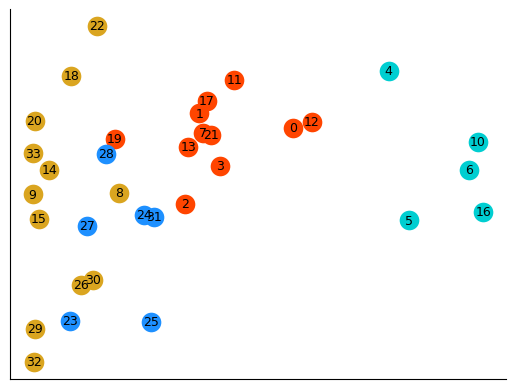

In [2]:
with open('output/example/args.json') as f:
    args = json.load(f)
# Nodes should start from number '1'
A_nx = nx.karate_club_graph()
mapping = {node: node + 1 for node in A_nx.nodes()}
A_nx = nx.relabel_nodes(A_nx, mapping)
embedding_path = train(A_nx, args)

In [3]:
# embedding_path = 'output\example\embed_afterLSTM_50.txt'
# Loading embeddings
with open(embedding_path) as f:
    embeddings = f.readlines()
    embeddings = [list(map(float, x.strip().split()[1:])) for x in embeddings]


In [4]:
# apply k-means clustering on embeddings
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
kmeans.labels_

array([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [5]:
y_true = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
normalized_mutual_info_score(y_true, kmeans.labels_)

0.3099495628509787

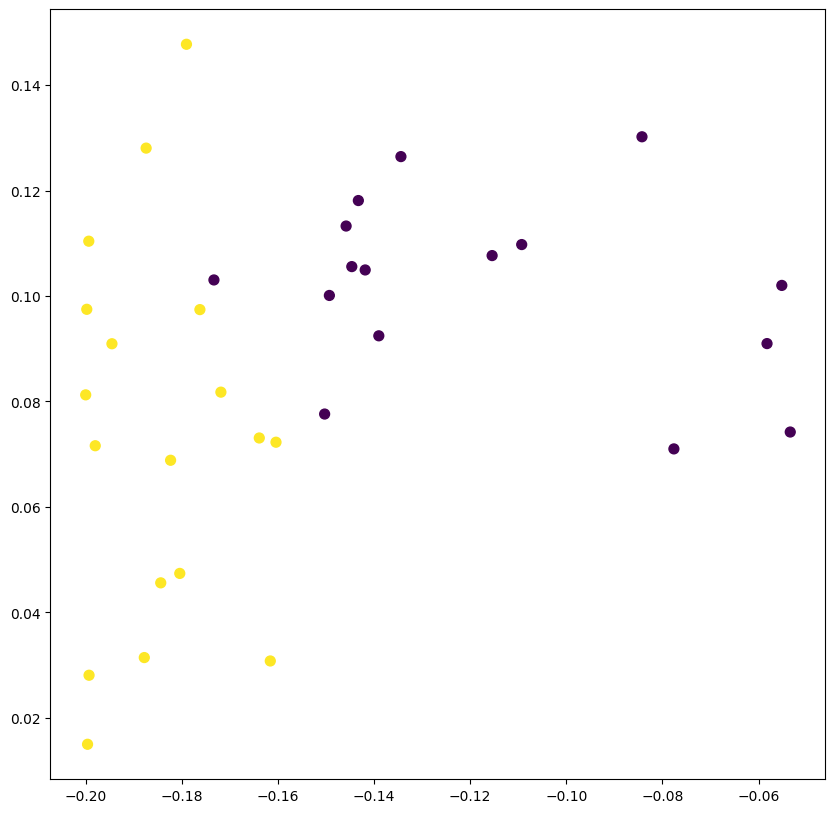

In [7]:
# plot the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(*zip(*embeddings), c=y_true, s=50, cmap='viridis')
plt.show()